In [1]:
%matplotlib inline
from qpms.constants import * # π  ℏ  eV eV2nm
import numpy as np
from matplotlib import pyplot as plt, tri
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import Normalize
ň = None
import math
from scipy.interpolate import interp2d
#from scipy.io import loadmat # because some of Sara's files are done by MATLAB

In [2]:
# auxilliary function to make a (n+1,)-sized mesh limit array from a (n,)-sized data point array
# used mainly for making the x and y arguments for matplotlib's pcolormesh method
def make_meshnodes(datapoints):
    datapoints = np.array(datapoints)
    if len(datapoints.shape) != 1 or len(datapoints) < 2:
        raise ValueError('datapoints must be a 1-dimensional numpy array or compatible and must contain at least 2 elements')
    meshnodes = np.empty((datapoints.shape[0]+1,))
    meshnodes[0] = datapoints[0] - (datapoints[1] - datapoints[0])/2
    meshnodes[1:-1] = (datapoints[:-1] + datapoints[1:]) / 2
    meshnodes[-1] = datapoints[-1] - (datapoints[-1] - datapoints[-2])/2
    return meshnodes

# Fig. 3 (k-λ lasing data and 2D dispersion simulations)

In [27]:
nrow = 5 # number of plot rows
xrange_nm = [520, 630]
yrange_invm = [-1.2e6,1.2e6]#None
preview_roughness=1
yrange_invum = [yrange_invm[0]/1e6, yrange_invm[1]/1e6]
freq_prune_interval_eV = 0.0002#0.00005 # workaround for the white lines appearing with pcolormesh()
# pre-calculated dispersions / lowest singular values
dispsim2d_files = ["/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x370_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x375_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x380_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x385_dispdata.npz",
                   "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nmE-inplane500k_380x390_dispdata.npz",
]

# Sara's measurement wavelength file
measurent_wl_nm_file = '/u/46/necadam1/unix/project/SaraRect/measurement/measurement_wavelengths_nm'

# Sara's intensity data; TODO
lasingdatafile_infixi = [('380x370-0pol-_PD',
            '380x370-90pol-_PD',
            '380x370_PD'),
            ('380x375-0pol-_PD',
            '380x375-90pol-_PD',
            '380x375_PD'),
            ('380x380-0pol-_PD',
            '380x380-90pol-_PD',
            '380x380_PD'),
            ('380x385-0pol-_PD',
            '380x385-90pol-_PD',
            '380x385_PD'),
            ('380x390-0pol-_PD',
            '380x390-90pol-_PD',
            '380x390_PD'),
]
lasingdatafile_prefix = '/u/46/necadam1/unix/project/SaraRect/measurement/'
intensityfile = '14'
           
lasingdatafile_postfix = '/%s.csv' % intensityfile

numap = 0.3
p0 = 200
pmax = 400
pc = 195
refindex = 1
clipint = 12000

dimension_labels = ['$380\\,\\mathrm{nm}\\times 370\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 375\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 380\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 385\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 390\\,\\mathrm{nm}$',
]

pyarrow_lambdas_nm = 1.52 * np.array([370,375,380,385,390])

In [29]:
# load and process the simulation data
dispsim2d_plotdata = list()
for dispsimfile in dispsim2d_files:
    dispdata = np.load(dispsimfile)
    # the data are calculated only for non-negative k_y; the other side is obtained by mirror symmetry
    ks_orig = dispdata['ks']
    nfreq, nk_orig = dispdata['leastSVs'].shape
    leastSVs_half = dispdata['leastSVs']
    ks = np.empty((nk_orig*2-1))
    ks[:nk_orig] = - ks_orig[0,::-1] # negative k's
    ks[nk_orig-1:] = ks_orig[0,:] # positive k's
    freqs = dispdata['freqs'][:,0]
    
    #prune freqs, otherwise white line artifacts might appear in pcolormesh rasterized output
    freqmask = np.ones(freqs.shape, dtype=bool)
    lastone = 0
    for freqi in range(1,nfreq):
        if freqs[freqi] < freqs[lastone] + freq_prune_interval_eV*eV/ℏ:
            freqmask[freqi] = False
        else:
            lastone = freqi
    freqs = freqs[freqmask]
    leastSVs_half = leastSVs_half[freqmask]
    nfreq = len(freqs)
    
    
    #ks = ks[ň,:]
    leastSVs = np.empty((nfreq, nk_orig*2-1))
    leastSVs[:,:nk_orig] = leastSVs_half[:,::-1] # negative k's
    leastSVs[:,nk_orig-1:] = leastSVs_half[:,:] # positive k's
    
    lambdas_nm = eV2nm(freqs/(eV/ℏ))#[ň,:]
    # sort by wavelength, not energy
    #lambdas_nm = lambdas_nm[::-1]
    #leastSVs = leastSVs[::-1]
    #print(lambdas_nm.shape,dispdata['leastSVs'].shape)
    #print(lambdas_nm[0],lambdas_nm[-1])
    print(lambdas_nm.shape, ks.shape, leastSVs.shape)
    dispsim2d_plotdata.append((freqs, lambdas_nm, ks, leastSVs))
    
# TODO load and process the measurement data
meas_wl_nm = np.loadtxt(measurent_wl_nm_file)
meas_wl = meas_wl_nm * 1e-9
energies = 2 * π * ℏ * c / meas_wl
measuredata = list()
for xyf_triple in lasingdatafile_infixi:
    trilist = list()
    for infix in xyf_triple: # (xpol, ypol, nopol)
        intensity = np.loadtxt(lasingdatafile_prefix+infix+lasingdatafile_postfix)
        nrows = intensity.shape[1]
        angles = np.arctan((np.arange(nrows)-pmax+pc)/pc * math.tan(math.asin(numap/refindex)))
        wavevectors = np.sin(angles)[ň,:] * (energies/(c * ℏ))[:,ň]
        trilist.append((meas_wl_nm, wavevectors, intensity, np.sum(intensity, axis=1)))
    measuredata.append(trilist)
print(np.amax(wavevectors))

(1478,) (1041,) (1478, 1041)
(1474,) (1041,) (1474, 1041)
(1478,) (1041,) (1478, 1041)
(1482,) (1041,) (1482, 1041)
(1479,) (1041,) (1479, 1041)
5110436.275966835


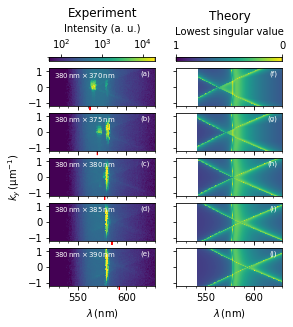

In [30]:
# the plot
f = plt.figure(1, (4, 4.5))
theory_cbnorm = Normalize(vmin=0, vmax=1, clip=False)
#experiment_cbnorm = Normalize(vmin=0, vmax=clipint, clip=True)
experiment_cbnorm = matplotlib.colors.LogNorm(vmin=50, clip=True)
axes1 = ImageGrid(#cf. https://matplotlib.org/tutorials/toolkits/axes_grid.html
                 f, 121,  # similar to subplot(111)
                 nrows_ncols=(5, 1),  # creates 5x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=False,
                 share_all=True,
                 cbar_location='top',
                 cbar_mode='single',
                 cbar_pad=.1,
                 cbar_size = "10 %",
                 )
axes2 = ImageGrid(#cf. https://matplotlib.org/tutorials/toolkits/axes_grid.html
                 f, 122,  # similar to subplot(111)
                 nrows_ncols=(5, 1),  # creates 5x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=False,
                 share_all=True,
                 cbar_location='top',
                 cbar_mode='single',
                 cbar_pad=.1,
                 cbar_size = "10 %",
                 )


for i in range(nrow):
    freqs, lambdas_nm, ks, leastSVs = dispsim2d_plotdata[i]
    ax = axes2[i] #axes[2*i+1]
    ax.set_xlim(xrange_nm)
    ax.set_ylim(yrange_invum)
    ax.set_xticks([550,600,])
    #ax.tick_params(axis='x',which='minor',bottom=True)
    ax.tick_params(axis='y', which='major', labelleft=False)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.set_xlabel('$\\lambda\,(\\mathrm{nm})$')
    ax.set_yticks([-1,0,1])
    #ax.set_ylabel('$k_y/\\mathrm{\\mu m^{-1}}$')
    im = ax.pcolormesh(make_meshnodes(lambdas_nm), make_meshnodes(ks)/1e6, 1- leastSVs.T, rasterized=True, norm=theory_cbnorm)
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.text(xrange_nm[0]+0.95*(xrange_nm[1]-xrange_nm[0]),
            yrange_invum[0]+0.95*(yrange_invum[1]-yrange_invum[0]),
            '(%c)' % (102+i), # 'f' + i in asci
            horizontalalignment='right',
            verticalalignment='top',
            color='white',
            fontsize = 'x-small'
           )
axes2.cbar_axes[0].colorbar(im)
axes2.cbar_axes[0].set_xticks([0,1])
axes2.cbar_axes[0].set_xticklabels(['1','0']) # We actually plotted 1 - SV, so modify the tick by hand
axes2.cbar_axes[0].set_xlabel("Lowest singular value", 
                             labelpad = 6)
axes2.cbar_axes[0].set_title('Theory', pad = 7)

for i in range(nrow):
    ax = axes1[i]#axes[2*i+0]
    ax.set_xlabel('$\\lambda\,(\\mathrm{nm})$')
    ax.set_xlim(xrange_nm)
    ax.set_ylim(yrange_invum)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.set_yticks([-1,0,1])
    if i == 2: ax.set_ylabel('$k_y\\,(\\mathrm{\\mu m^{-1}})$')
    lambdas_nm, ks, intensity, _ = measuredata[i][2] # 2 = no polarisation
    triang = tri.Triangulation(np.broadcast_to(lambdas_nm[:,ň], ks.shape).flatten()[::preview_roughness], ks.flatten()[::preview_roughness]/1e6)
    im = ax.tripcolor(triang, intensity.flatten()[::preview_roughness], rasterized=True, norm=experiment_cbnorm
                     )
    #interp_intensity = interp2d(np.broadcast_to(lambdas_nm[:,ň], ks.shape).flatten(), ks.flatten(), intensity.flatten(), fill_value = np.nan)
    #plotlambdas_nm = np.linspace(*xrange_nm, 500)[:,ň]
    #plotks_invum = np.linspace(-1,1,400)[ň,:]
    #plotintensity = interp_intensity(plotlambdas_nm, plotks_invum)
    #im = ax.pcolormesh(plotlambdas_nm, ploks_invum, plotintensity, rasterized=true)
    ax.text(xrange_nm[0]+0.05*(xrange_nm[1]-xrange_nm[0]),
            yrange_invum[0]+0.95*(yrange_invum[1]-yrange_invum[0]),
            dimension_labels[i],         
            horizontalalignment='left',
            verticalalignment='top',
            color='white',
            fontsize = 'x-small'
           )
    ax.text(xrange_nm[0]+0.95*(xrange_nm[1]-xrange_nm[0]),
            yrange_invum[0]+0.95*(yrange_invum[1]-yrange_invum[0]),
            '(%c)' % (97+i), # 'a' + i in asci
            horizontalalignment='right',
            verticalalignment='top',
            color='white',
            fontsize = 'x-small'
           )
    ax.arrow(pyarrow_lambdas_nm[i], yrange_invum[0], 0, (yrange_invum[0]-yrange_invum[1])*.08, head_starts_at_zero=True, width=0.01, clip_on=False, color='r')
axes1.cbar_axes[0].colorbar(im)
#axes1.cbar_axes[0].xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(.2, ), numdecs=1, numticks=5))
#axes1.cbar_axes[0].set_xticks([])
#axes1.cbar_axes[0].xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
#axes1.cbar_axes[0].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
#axes1.cbar_axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# Without this, some fscked up labels on the left...
axes1.cbar_axes[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

axes1.cbar_axes[0].xaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext(base=10.0))
axes1.cbar_axes[0].xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numdecs=1, numticks=5))
#axes1.cbar_axes[0].set_xticks([0,clipint])
#axes1.cbar_axes[0].set_xticklabels(['0','max'])
axes1.cbar_axes[0].set_xlabel("Intensity (a. u.)", 
                              labelpad = 4.7
                             )
axes1.cbar_axes[0].set_title('Experiment',
                            pad = 7)
    
f.subplots_adjust(left=0.15, right=0.96, top=0.83)
f.savefig("figs/Fig3_Marek%s_base10.pdf"%intensityfile, dpi=600)
#f.savefig("figs/test.png", dpi=1200)

In [31]:
axes2.cbar_axes[0].xaxis.get_tick_padding()

3.5

In [21]:
axes1.cbar_axes[0].xaxis.get_tick_padding()

3.5

In [18]:
b = axes1.cbar_axes[0].bbox
b.x1, b.x0, b.y1, b.y0

(149.2363636363636, 43.199999999999996, 268.91999999999996, 265.1470588235294)

In [19]:
b = axes2.cbar_axes[0].bbox
b.x1, b.x0, b.y1, b.y0

(276.47999999999996, 170.44363636363633, 268.91999999999996, 265.1470588235294)

In [22]:
axes1.cbar_axes[0].xaxis.get_label_position()

'top'

In [23]:
axes1.cbar_axes[0].get_xaxis_transform()

# Fig. 2 parts

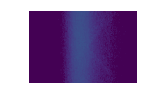

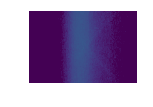

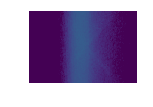

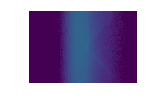

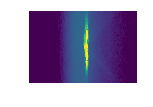

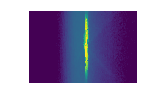

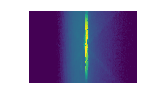

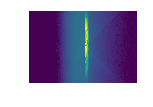

In [152]:
lasingdatafile_infix = '380x380_PD'

pumps = [8,9,10,11,12,13,14,15]

preview_roughness_f2=1
xrange_nm_f2 = [500,650]
yrange_invum_f2 = [-1,1]

for intensityfile in pumps:
    lasingdatafile_postfix = '/%02d.csv' % intensityfile
    intensity = np.loadtxt(lasingdatafile_prefix+lasingdatafile_infix+lasingdatafile_postfix)
    f = plt.figure(intensityfile, (1.5, 1))
    ax = f.add_axes((0,0,1,1))
    triang = tri.Triangulation(np.broadcast_to(lambdas_nm[:,ň], ks.shape).flatten()[::preview_roughness_f2], ks.flatten()[::preview_roughness_f2]/1e6)
    im = ax.tripcolor(triang, intensity.flatten()[::preview_roughness_f2], rasterized=True, norm=experiment_cbnorm)
    ax.set_xlim(xrange_nm_f2)
    ax.set_ylim(yrange_invum_f2)
    ax.set_axis_off()
    f.savefig("figs/Fig2_Marek%02d.pdf"%intensityfile, dpi=600)


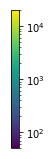

In [160]:
f = plt.figure(16, (.6,2))

cbax = f.add_axes((.1,.02,.2,.96))
cb = plt.colorbar(im, cax = cbax)
#cb = plt.colorbar(ax1, cax = cbaxes)  
f.savefig("figs/Fig2_Marek_colorbar.pdf")

# Fig. 4 (lasing data integrated over k and 1D dispersion simulations at the Γ-point)

In [85]:
nrow = 5 # number of plot rows
xrange_nm = [550, 600]
freq_prune_interval_eV = 0.001#0.00005 # workaround for the white lines appearing with pcolormesh()
# pre-calculated dispersions / lowest singular values
dispsim_k0_files = [
    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nm3k_380x370_crosscut.npz",
    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nm3k_380x375_crosscut.npz",
    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nm3k_380x380_crosscut.npz",
    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nm3k_380x385_crosscut.npz",
    "/m/phys/project/qd/Marek/dispdata/SaraRect_lMax3MieInterp42nm3k_380x390_crosscut.npz",
]

dimension_labels = ['$380\\,\\mathrm{nm}\\times 370\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 375\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 380\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 385\\,\\mathrm{nm}$',
                   '$380\\,\\mathrm{nm}\\times 390\\,\\mathrm{nm}$',
]

irrep_labels = {"B2''":"$B_2''$",
                "B2'":"$B_2'$",
                "A1''":"$A_1''$",
                "A1'":"$A_1'$",
                "A2''":"$A_2''$",
                "B1''":"$B_1''$",
                "A2'":"$A_2'$", 
                "B1'":"$B_1'$"}

irreps_to_plot = [#"A1'",
                  
                  "B1'",
                  "B2'",
"A2'",]

polarisation_labels = ['$x$-filter', '$y$-filter', 'none']

In [86]:
# load and process the simulation data
dispsimk0_plotdata = list()
for dispsimfile in dispsim_k0_files:
    dispdata = np.load(dispsimfile)
    # the data are calculated only for non-negative k_y; the other side is obtained by mirror symmetry
    freqs = dispdata['freqs']
    lambdas_nm = eV2nm(freqs/(eV/ℏ)) 
    irrepdata = {key: dispdata[key] for key in irrep_labels.keys()}
    dispsimk0_plotdata.append((lambdas_nm, irrepdata))

# measurement data are ready from the previous fig

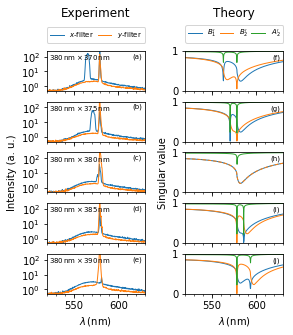

In [101]:
# the plot
f = plt.figure(1, (4.0, 4.5))
theory_cbnorm = Normalize(vmin=0, vmax=1, clip=False)
experiment_cbnorm = Normalize(vmin=0, vmax=clipint, clip=True)
axes1 = ImageGrid(#cf. https://matplotlib.org/tutorials/toolkits/axes_grid.html
                 f, # 121,  # similar to subplot(111)
                 (0.15, 0.1, 0.34, 0.75), # alternative (x, y, width, height)
                 nrows_ncols=(5, 1),  # creates 5x2 grid of axes
                 axes_pad=0.15,  # pad between axes in inch.
                 aspect=False,
                 #share_all=True,
                 #cbar_location='top',
                 cbar_mode=None,
                 #cbar_pad=.1,
                 #cbar_size = "10 %",
                 )
axes1[0].set_title('Experiment',
                            pad = 34)
axes2 = ImageGrid(#cf. https://matplotlib.org/tutorials/toolkits/axes_grid.html
                 f, #122,  # similar to subplot(111)
                 (0.63, 0.1, 0.34, 0.75), # alternative
                 nrows_ncols=(5, 1),  # creates 5x2 grid of axes
                 axes_pad=0.15,  # pad between axes in inch.
                 aspect=False,
                 share_all=True,
                 #cbar_location='top',
                 cbar_mode=None,
                 #cbar_pad=.1,
                 #cbar_size = "10 %",
                 )
axes2[0].set_title('Theory', pad = 34)

for i in range(nrow):
    lambdas_nm, leastSVs = dispsimk0_plotdata[i]
    ax = axes2[i] #axes[2*i+1]
    ax.set_xlim(xrange_nm)
    ax.set_ylim([0,1])
    ax.set_xticks([550,600,])
    #ax.tick_params(axis='x',which='minor',bottom=True)
    #ax.tick_params(axis='y', which='major', labelleft=False)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.set_xlabel('$\\lambda\\,(\\mathrm{nm})$')
    ax.set_yticks([0,1])
    if i == 2: ax.set_ylabel('Singular value')
    handles = list()
    for rep in irreps_to_plot:
        handle, = ax.plot(lambdas_nm, leastSVs[rep], label=irrep_labels[rep],  ls='--' if rep == "B2'" and i == 2 else '-', lw=1)
        handles.append(handle)
    #if i == 4: # make the legend only for the last one
    #    ax.legend(handles=handles, fontsize='xx-small')
    if i == 0: # cf. https://matplotlib.org/users/legend_guide.html#legend-location
        ax.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
            ncol=len(irreps_to_plot), mode="expand", borderaxespad=0.,
            fontsize='x-small')
    ax.text(xrange_nm[0]+0.97*(xrange_nm[1]-xrange_nm[0]),
            0.92,
            '(%c)' % (102+i), # 'a' + i in asci
            horizontalalignment='right',
            verticalalignment='top',
            color='k',
            fontsize = 'x-small'
           )

for i in range(nrow):
    ax = axes1[i]#axes[2*i+0]
    ax.set_xlabel('$\\lambda\\,(\\mathrm{nm})$')
    ax.set_xlim(xrange_nm)
    #ax.set_ylim(yrange_invum)
    ax.set_xticks([550,600,])
    #ax.set_yticks([0,1])
    #ax.set_yticklabels(['0', 'max'])
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    #ax.set_yticks([-1,0,1])
    #if i == 2: ax.set_ylabel('Intensity (a. u.)')
    if i == 2: ax.set_ylabel('Intensity (a. u.)')
    maxint = max(np.amax(measuredata[i][j][3]) for j in range(3))
    for j in range(2):
        lambdas_nm, wavevectors,  intensity, intensity_sum = measuredata[i][j] # 2 = no polarisation
        intensity_max = np.amax(intensity, axis=1)
        #print(lambdas_nm.shape, wavevectors.shape, intensity.shape, intensity_sum.shape)
        #ax.plot(lambdas_nm, intensity_sum/maxint, label = polarisation_labels[j])
        ax.set_yscale('log')
        ax.set_ylim([0.5,250])
        ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, numticks=3))
        #ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10, numticks=30))
        #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #ax.plot(lambdas_nm, intensity_sum/maxint, label = polarisation_labels[j])
        ax.plot(lambdas_nm, intensity_max/100, label = polarisation_labels[j], lw=1)
    ax.text(xrange_nm[0]+0.02*(xrange_nm[1]-xrange_nm[0]),
            0.75*ax.get_ylim()[1], #yrange_invum[0]+0.95*(yrange_invum[1]-yrange_invum[0]),
            dimension_labels[i],         
            horizontalalignment='left',
            verticalalignment='top',
            color='k',
            fontsize = 'x-small'
           )
    ax.text(xrange_nm[0]+0.97*(xrange_nm[1]-xrange_nm[0]),
             0.75*ax.get_ylim()[1],
            '(%c)' % (97+i), # 'a' + i in asci
            horizontalalignment='right',
            verticalalignment='top',
            color='k',
            fontsize = 'x-small'
           )
    if i == 0: # cf. https://matplotlib.org/users/legend_guide.html#legend-location
        ax.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
            ncol=3, mode="expand", borderaxespad=0.,
            fontsize='x-small')

    
#f.subplots_adjust(left=0.15, right=0.96, top=0.70,) # Not used, grid coordinates given explicitly above
f.savefig("figs/Fig4_Marek%s.pdf"%intensityfile, dpi=600)
f.savefig("figs/test4.png", dpi=1200)